# Truss connector

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

# --UNITS--
# displacement: mm
# stress: MPa
# force: N
# E = 2e5 MPa (AISI Carbon Steel)
# nu = 0.27
# rho = 7.85e-3 
# yield = 490 MPa

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.029957056045532227


3 coordinate transform: 12.903728008270264
2 read results: 17.612088203430176
1 total mesh and result loading: 17.855468034744263
1 total edge processing: 0.8526580333709717


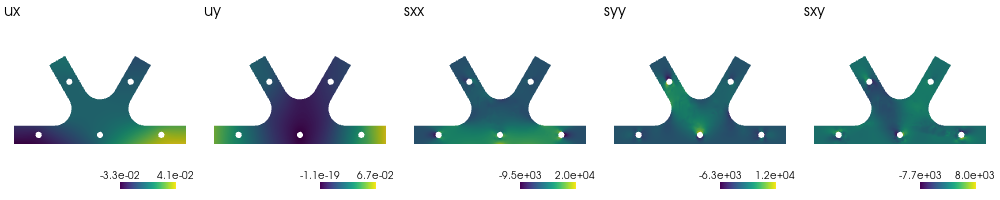

In [2]:
# load mesh and solver results
op2File = 'data/connector/v1.0/connectorDesign03.op2'
geom = MeshGeom(op2File, thickness=6.35)
plotScalarFields(geom.mesh, geom.resDf)

In [ ]:
# load using the alternative format
# meshFile = 'data/connector/v1.0/connectorDesign03.vtk'
# pickleFile = 'data/connector/v1.0/connectorDesign03.p'
# geom = MeshGeom(meshFile=meshFile, pickleFile=pickleFile)
# plotScalarFields(geom.mesh, geom.resDf)

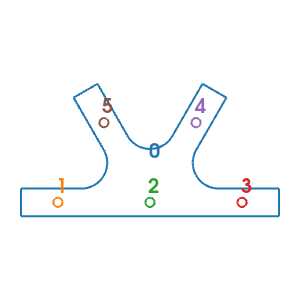

In [3]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.071808 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.708668 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                    Test loss                                                                                                                                                                     Test metric
0         [1.87e+05, 5.71e+05, 4.09e+05, 5.42e+06, 5.22e+04, 1.33e-07, 6.70e-07, 9.70e+04, 3.50e+06, 8.99e+04, 4.09e+06, 1.98e+05, 5.15e+06, 4.61e+03, 6.66e+05, 1.04e+05, 1.82e+06]    [1.93e+05, 5.74e+05, 4.04e+05, 4.66e+06, 4.47e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 2.24e+07
  test loss: 5.88e+06
  test metric: []

'train' took 0.275228 s

Compiling model...
'compile' took 1.305162 s

Initializing variables...
Training mo

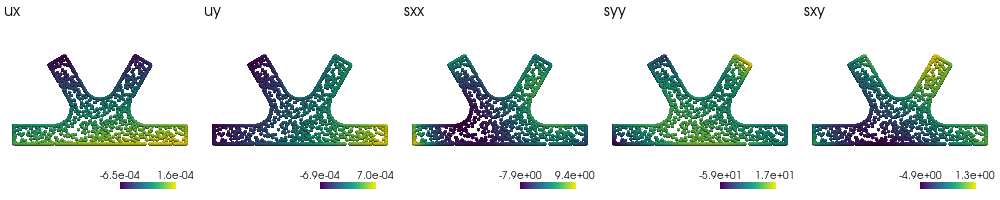

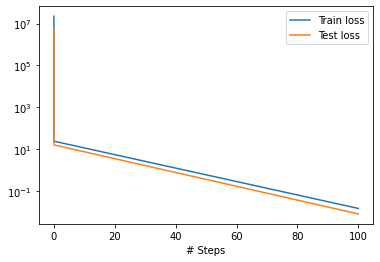

In [7]:
# supports
xSup = SupportBC(geom, bndId=2, U=0, component=0)
ySup = SupportBC(geom, bndId=2, U=0, component=1)

# free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# loaded edges
xTr1 = TractionBC(geom, bndId=1, T=-1.0/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr5 = TractionBC(geom, bndId=5, T=(-3/(4*np.sqrt(3)))/geom.bndAreaDict[5], component=0)
yTr5 = TractionBC(geom, bndId=5, T=(3/4)/geom.bndAreaDict[5], component=1)

xTr4 = TractionBC(geom, bndId=4, T=(1/(4*np.sqrt(3)))/geom.bndAreaDict[4], component=0)
yTr4 = TractionBC(geom, bndId=4, T=(1/4)/geom.bndAreaDict[4], component=1)

xTr3 = TractionBC(geom, bndId=3, T=(1 + 1/(2*np.sqrt(3)))/geom.bndAreaDict[3], component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# problem setup
bndNumSamplesDir = {0: 800, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}
# bndNumSamplesDir = {bndId:int(l*100) for bndId,l in geom.bndLensDict.items()}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xSup,ySup, xTr0,yTr0,xTr1,yTr1,xTr3,yTr3,xTr4,yTr4,xTr5,yTr5]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=500, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e4, 1e4, 1e3]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=100, display_every=100)
dde.postprocessing.plot_loss_history(losshistory)

# test
pred = model.predict(data.train_x)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(data.train_x))
plotScalarFields(pc, predDf)

In [ ]:
intResDf = geom.sampleRes(data.train_x)
MAE = (predDf-intResDf.drop(columns='vonMises')).abs().mean()
print(MAE)
plotScalarFields(pc, intResDf)

In [ ]:
MAE = (predDf-intResDf.drop(columns='vonMises')).abs().mean()
print(MAE)

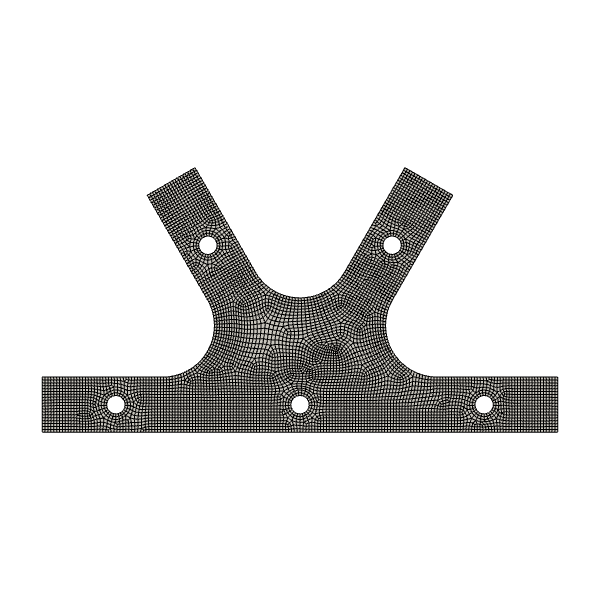

In [5]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=True)
plotter.show(window_size=(600,600), cpos='xy');

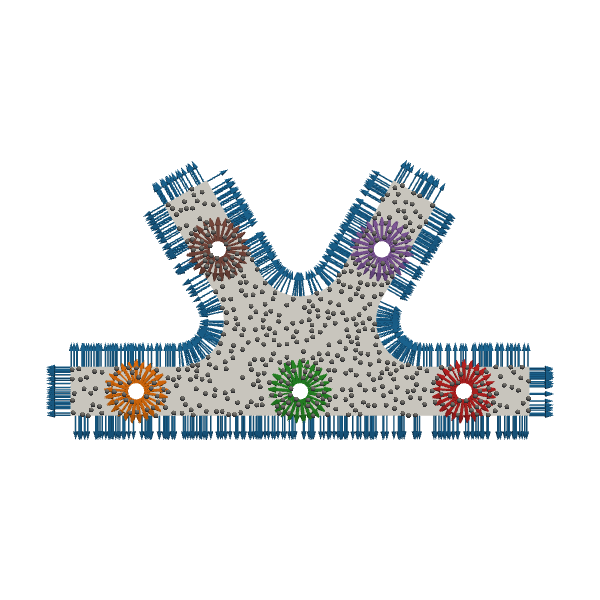

In [8]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')


# boundary samples
# colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');

In [ ]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')


# boundary samples
# colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');